## Extracting variables from BARRA-R2 for specific locations
Detailed description of paramters here: https://opus.nci.org.au/spaces/NDP/pages/338002591/BARRA2+Parameter+Descriptions 

In [1]:
import xarray as xr
import os
import sys
import dask.distributed
import glob
from dask.distributed import Client
import tempfile
import dask
import numpy as np
import time
import matplotlib.pyplot as plt

sys.path.append('/home/565/dh4185/mn51-dh4185/repos_collab/dataset_finder/')
from dataset_finder import *

In [2]:
# Dask settings
dask.config.set({
    #'array.chunk-size': "256 MiB",
    #'array.slicing.split_large_chunks': True, 
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

client = Client(n_workers=20, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43717 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43717/status,
Dashboard: /proxy/43717/status,Workers: 20
Total threads: 20,Total memory: 1.15 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39439,Workers: 20
Dashboard: /proxy/43717/status,Total threads: 20
Started: Just now,Total memory: 1.15 TiB
Comm: tcp://127.0.0.1:46681,Total threads: 1
Dashboard: /proxy/36477/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:44261,


In [3]:
locations = {'Darwin':{'Lat':-12.42,'Lon':130.89,'Elev':30}, # BOM station: 014015
             'Cairns':{'Lat':-16.87,'Lon':145.75,'Elev':2}, # BOM station: 031011
             'Brisbane':{'Lat':-27.48,'Lon':153.04,'Elev':8}, # BOM station: 040913
             'Longreach':{'Lat':-23.44,'Lon':144.28,'Elev':192}, # BOM station: 036031
             'Mildura':{'Lat':-34.23,'Lon':142.09,'Elev':50}, # BOM station: 076031
             'Adelaide':{'Lat':-34.95,'Lon':138.51,'Elev':2}, # BOM station: 023034
             'Perth':{'Lat':-31.92,'Lon':115.87,'Elev':25}, # BOM station: 009225
             'Sydney':{'Lat':-33.95,'Lon':151.17,'Elev':39}, # BOM stations: 066062/066214
             'Melbourne':{'Lat':-37.67,'Lon':144.83,'Elev':31}, # BOM stations: 086071/086338
             'Canberra':{'Lat':-35.31,'Lon':149.19,'Elev':577}, # BOM station: 070351
             'Hobart':{'Lat':-42.89,'Lon':147.33,'Elev':51}, # BOM station: 094029
             'Thredbo':{'Lat':-36.50,'Lon':148.29,'Elev':1380}} # BOM station: 071041

vars_1hr_list = ['tas','hurs','huss','sfcWind','psl','uas','vas','clt','rsds','rsdsdir']
vars_day_list = ['tasmax','tasmin','huss','psl','sfcWind','sfcWindmax','rsds','rsdsdir']

vars_1hr = {'temperature':['tas'],
              'humidity_relative':['hurs'],
              'humidity_specific':['huss'],
              'wind_speed_10m':['sfcWind'],
              'pressure':['psl'], 
              'wind_direction_u':['uas'],
              'wind_direction_v':['vas'],
              'cloud_cover':['clt'],
              'solar_global':['rsds'], #  Its direct component has not accounted for the solar zenith angle. This parameter can be treated as an estimate of global horizontal irradiance (GHI).
              'solar_direct':['rsdsdir']}  # The parameter has been corrected for the solar zenith angle and the effect of topography.

vars_day = {'temperature_max':['tasmax'],
              'temperature_min':['tasmin'],
              # 'humidity_relative_max':['hurs'], # get from hourly data, needed for dew point temperature
              # 'humidity_relative_min':['hurs'], # get from hourly data, needed for dew point temperature
              'humidity_specific_max':['huss'], # get from hourly data, needed for dew point temperature
              'humidity_specific_min':['huss'], # get from hourly data, needed for dew point temperature
              'pressure':['psl'], # needed to calculate dew point
              'wind_speed_10m':['sfcWind'],
              'wind_speed_10m_max':['sfcWindmax'],
              'solar_global':['rsds'], #  Its direct component has not accounted for the solar zenith angle. This parameter can be treated as an estimate of global horizontal irradiance (GHI).
              'solar_direct':['rsdsdir']}  # The parameter has been corrected for the solar zenith angle and the effect of topography.

In [4]:
####< Functions
# Function to compute great-circle distance using NumPy (vectorised)
def great_circle_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in km

def update_locations(da_sftlf,dict_locations):
    ### Find nearest grid cell on land to lat/lon coordinates from stations
    # Extract grid information
    latitudes = da_sftlf['lat'].values
    longitudes = da_sftlf['lon'].values
    valid_mask = da_sftlf.values >= 90  # Mask where terrain fraction is at least 90
    
    # Get valid lat/lon pairs
    valid_lats, valid_lons = np.meshgrid(latitudes, longitudes, indexing='ij')  # Ensure correct shape
    valid_lats, valid_lons = valid_lats[valid_mask], valid_lons[valid_mask]  # Apply mask
    
    # Find the closest valid grid cell for each location & store in a new dictionary
    updated_locations = {}
    for name, info in dict_locations.items():
        lat, lon, elev = info['Lat'], info['Lon'], info['Elev']
        distances = great_circle_distance(lat, lon, valid_lats, valid_lons)
        
        min_idx = np.argmin(distances)  # Index of closest point
        new_lat, new_lon = valid_lats[min_idx], valid_lons[min_idx]
        
        updated_locations[name] = {'Lat': new_lat, 'Lon': new_lon, 'Elev': elev}  # Preserve elevation
        
    return updated_locations
             
def preprocess_location(ds,lat,lon):
    return ds.sel(lat=lat,lon=lon, method="nearest")
             # .sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [12]:
# model dictionary
model_dict = {
    "BARRA-R2": {"root_dir":"/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/{}/",
                 "sftlf":"/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/sftlf/latest/sftlf_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc",
                 "grid": "AUS-11",
                 "org": "BOM",
                 "gcms":{
                     "ERA5":{"mdl_run":"hres","version": "v1","created":"latest"}}},
    "BARPA-R":{"root_dir":"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/{}/{}/{}/{}/{}/{}/",
               "sftlf":"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/fx/sftlf/latest/sftlf_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_fx.nc",
               "grid": "AUS-15",
               "org": "BOM",
               "gcms":{
                   "ACCESS-ESM1-5":{"mdl_run":"r6i1p1f1","version": "v1-r1","created": "latest"},
                   "ACCESS-CM2":{"mdl_run":"r4i1p1f1","version": "v1-r1","created": "latest"},
                   "CESM2":{"mdl_run":"r11i1p1f1","version": "v1-r1","created": "latest"},
                   "CMCC-ESM2":{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"},
                   "EC-Earth3":{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"},
                   "MPI-ESM1-2-HR":{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"},
                   "NorESM2-MM":{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"}}}
    "CCAM-v2203-SN":{"root_dir":"/g/data/hq89/CCAM/output/CMIP6/DD/AUS-10i/CSIRO/{}/{}/{}/{}/{}/{}/",
               "sftlf":"ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2203-SN/v1-r1/fx/sftlf/v20231206/sftlf_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1.nc",
               "grid": "AUS-10i",
               "org": "CSIRO",
               "gcms":{
                   "ACCESS-ESM1-5":{"mdl_run":"r6i1p1f1","version": "v1-r1","created": "latest"},
                   "ACCESS-CM2":{"mdl_run":"r4i1p1f1","version": "v1-r1","created": "latest"},
                   "CESM2":{"mdl_run":"r11i1p1f1","version": "v1-r1","created": "latest"},
                   "CMCC-ESM2":{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"},
                   "CNRM-ESM2-1":{"mdl_run":"r1i1p1f2","version": "v1-r1","created": "latest"},
                   "EC-Earth3",:{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"},
                   "NorESM2-MM":{"mdl_run":"r1i1p1f1","version": "v1-r1","created": "latest"}}}
}

In [22]:
#parameters
HOURLY_FREQ = True
_scenario = "historical"
_rcm = "BARPA-R"
_gcm = "ACCESS-ESM1-5"
start_y = 1985
end_y = 2014

out_dir = "/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/"

In [23]:
freq = "1hr" if HOURLY_FREQ else "day"

in_dir = model_dict[_rcm]["root_dir"]


In [19]:
# Create a plot with Cartopy
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the background data (assumes barra_sftlf is a 2D xarray DataArray)
barra_sftlf.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="terrain", alpha=0.6)

# Add geographical features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot locations with red dots and labels
for name, info in locations.items():
    ax.plot(info['Lon'], info['Lat'], 'ro', markersize=5, transform=ccrs.PlateCarree())  # Red dots
    ax.text(info['Lon'] + 0.5, info['Lat'], name, fontsize=9, transform=ccrs.PlateCarree())

# Set the extent (optional: adjust for better visibility)
ax.set_extent([112, 155, -44, -10])  # Adjust based on your data
ax.set_label("Land Fraction (%)")

# Show the map
plt.title("Locations on the BARRA Map")
plt.show()

NameError: name 'ccrs' is not defined

/jobfs/141887335.gadi-pbs/ipykernel_1011510/3463616377.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


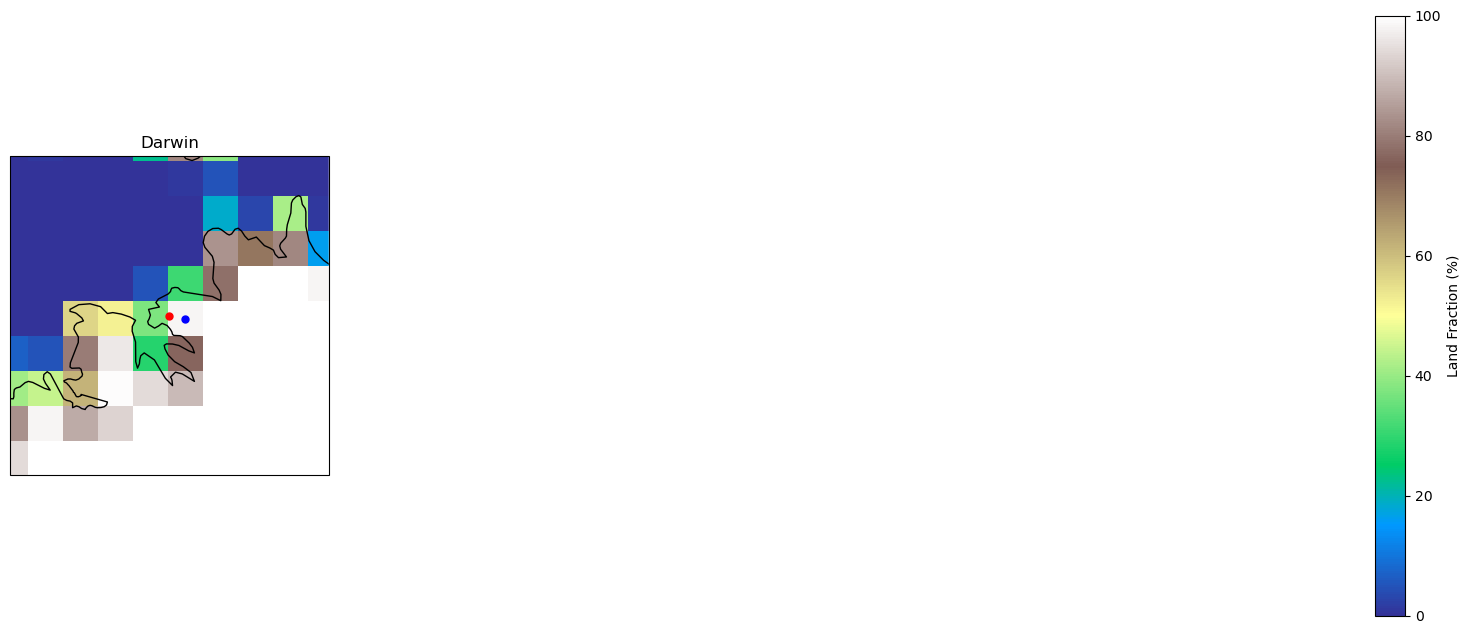

In [8]:
# Find the closest valid grid cell for each location
closest_points = {}
for name, info in locations.items():
    lat, lon = info['Lat'], info['Lon']
    distances = great_circle_distance(lat, lon, valid_lats, valid_lons)
    
    min_idx = np.argmin(distances)  # Index of closest point
    closest_points[name] = (valid_lats[min_idx], valid_lons[min_idx])

# Create facet plot
num_locs = len(locations)
cols = 4  # Number of columns in facet grid
rows = int(np.ceil(num_locs / cols))  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten for easy iteration

# Get colorbar limits
vmin, vmax = barra_sftlf.min(), barra_sftlf.max()

for ax, (name, info) in zip(axes, locations.items()):
    # ax.set_title(name)

    # Define zoomed extent
    zoom_factor = 0.5  # Adjust zoom level (higher = less zoom)
    lat, lon = info['Lat'], info['Lon']
    lat_range = (lat - zoom_factor, lat + zoom_factor)
    lon_range = (lon - zoom_factor, lon + zoom_factor)
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())

    # Plot land fraction map
    im = barra_sftlf.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="terrain", vmin=vmin, vmax=vmax, add_colorbar=False)
    
    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot original location (red)
    ax.plot(info['Lon'], info['Lat'], 'ro', markersize=5, transform=ccrs.PlateCarree(), label="Original Location")
    
    # Plot adjusted location (blue)
    if closest_points[name] != (None, None):
        ax.plot(closest_points[name][1], closest_points[name][0], 'bo', markersize=5, transform=ccrs.PlateCarree(), label="Closest Valid Cell")

    # Add a title with the location name
    ax.set_title(name, fontsize=12)
    
# Remove empty subplots if any
for i in range(num_locs, len(axes)):
    fig.delaxes(axes[i])

# Add single colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Land Fraction (%)")

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar

# Show figure
plt.show()

### Check daily data availability across models

In [7]:
%%time
#< Specify datasets - do this to find out what models have the required variables
all_data_day = get_datasets("ACS_DS",
                        # rcm = "BARRA-R2",
                        scenario = ["historical","ssp126","ssp370"],
                        timescale ="day",
                        year = year_range(1985, 2070))

select_data_day = all_data_day.select(var = vars_day_list, exact_match=True).condense("scenario")
# select_data_day

CPU times: user 17min 43s, sys: 3min 14s, total: 20min 58s
Wall time: 23min 31s


### Check hourly data availability across models

In [39]:
%%time
#< Specify datasets - do this to find out what models have the required variables
all_data_1hr = get_datasets("ACS_DS",
                        # rcm = "NARCliM",
                        scenario = ["historical","ssp126","ssp370"],
                        timescale = "1hr",
                        year = year_range(1985, 2070))

select_data_1hr = all_data_1hr.select(var = vars_1hr_list, exact_match=True).condense("scenario")
# select_data_1hr

CPU times: user 4min 33s, sys: 28.1 s, total: 5min 1s
Wall time: 5min 19s


In [22]:
matching_day
# matching_1hr

,grid,org,gcm,mdl_run,rcm,ver,timescale,,var,date_created,scenario,year,month
0,AUS-15,BOM,ACCESS-CM2,r4i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
1,AUS-15,BOM,ACCESS-ESM1-5,r6i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
2,AUS-15,BOM,CESM2,r11i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
3,AUS-15,BOM,CMCC-ESM2,r1i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
4,AUS-15,BOM,EC-Earth3,r1i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
5,AUS-15,BOM,MPI-ESM1-2-HR,r1i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
6,AUS-15,BOM,NorESM2-MM,r1i1p1f1,BARPA-R,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20231001, v20240401",historical,1985 to 2014,1 to 12
7,AUST-04,BOM,ACCESS-ESM1-5,r6i1p1f1,BARPA-C,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20241201",historical,1995 to 2004,1 to 12
8,AUST-04,BOM,EC-Earth3,r1i1p1f1,BARPA-C,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin","latest, v20241201",historical,1995 to 2004,1 to 12
9,AUS-10i,CSIRO,ACCESS-CM2,r4i1p1f1,CCAM-v2203-SN,v1-r1,day,,"huss, psl, rsds, rsdsdir, sfcWind, sfcWindmax, tasmax, tasmin",v20231206,historical,1985 to 2014,1 to 12


In [21]:
matching_day = select_data_day.find_matches(select_data_1hr, exclude_keys = "timescale")
matching_1hr = select_data_1hr.find_matches(select_data_day, exclude_keys = "timescale")

## Process extraction of variables

In [ ]:
%%time

# ==== MAIN LOOP ====
import time
_vars = vars_1hr if HOURLY_FREQ else vars_day


print(f"---------- {_rcm} for '{freq}' data ----------")
updated_locations = update_locations(xr.open_dataset(model_dict[_rcm]["sftlf"]).sftlf,locations)

for loc in updated_locations:
    start_time_loc = time.time()  # Start timer
    print(f"========================== {loc} =======================")
    lat = updated_locations[loc]['Lat']
    lon = updated_locations[loc]['Lon']
    print(f"Lat: {lat}, Lon: {lon}")
    
    for _gcm in model_dict[_rcm]["gcms"]:
        start_time_gcm = time.time()  # Start timer
        print(f"***** {_gcm} *****")

        out_file = (
            f"{out_dir}{loc}_"
            f"{model_dict[_rcm]['grid']}_"
            f"{_gcm}_{_scenario}_"
            f"{model_dict[_rcm]['gcms'][_gcm]['mdl_run']}_"
            f"{model_dict[_rcm]['org']}_"
            f"{_rcm}_{model_dict[_rcm]['gcms'][_gcm]['version']}_"
            f"{freq}_{start_y}-{end_y}.nc"
        )
        if not os.path.exists(out_file):
            print(f"Processing: {out_file}.....")
    
            var_list = []
            var_name_list = []   
    
            for _var in _vars:
                start_time_var = time.time()  # Start timer
                print(f"{_var}: {_vars[_var]}")
                _timescale = "1hr" if HOURLY_FREQ else "day"
        
                if _timescale == "day" and (_var == 'humidity_specific_max' or _var == 'humidity_specific_min'):
                    print(f"Use hourly data for {_var}.")
                    _timescale = "1hr"
        
                in_dir = model_dict[_rcm]["root_dir"]
                all_data = get_datasets("ACS_DS",
                                rcm = _rcm,
                                gcm = _gcm,
                                scenario = _scenario,
                                grid = model_dict[_rcm]["grid"],
                                org = model_dict[_rcm]["org"],
                                mdl_run = model_dict[_rcm]["gcms"][_gcm]["mdl_run"],
                                ver = model_dict[_rcm]["gcms"][_gcm]["version"],
                                timescale = _timescale,
                                year = year_range(start_y, end_y)).select(var = _vars[_var], exact_match=True)
    
                da = xr.open_mfdataset(all_data.get_files(), parallel=True,
                                       preprocess=lambda ds: preprocess_location(ds, lat, lon))[_vars[_var][0]]
                da = da.chunk({'time': -1})
    
                if _var == 'humidity_specific_max' or _var == 'humidity_specific_min':
                    print(f"Resample hourly data for {_var}.")
                    if _var == 'humidity_specific_max':
                        da = da.resample(time='1D').max().rename('hussmax')
                    elif _var == 'humidity_specific_min':
                        da = da.resample(time='1D').min().rename('hussmin')
                
                if _timescale == "day":
                    da['time'] = da['time'].dt.floor('D')
                    da = da.sel(time=~da.get_index("time").duplicated())
                elif _timescale == "1hr" and _vars[_var][0] in ['clt','rsds','rsdsdir']:
                    da['time'] = da['time'].dt.floor('h')
                    da = da.sel(time=~da.get_index("time").duplicated())
                # print(da)
                
                var_list.append(da.to_dataset())
                print(f"Processing time for {_var}: {((time.time() - start_time_var)/60):.2f} minutes\n")
    
            cleaned_list = [da.drop_vars(["bnds","height","level_height","model_level_number","sigma"], errors="ignore") for da in var_list]
        
            da_var = xr.merge(cleaned_list)
            print(da_var)
            da_var.to_netcdf(out_file)
            print(f"Processing time for {_rcm}-{_gcm}: {((time.time() - start_time_gcm)/60):.2f} minutes\n")
    
        print(f"Processing time for {loc}: {((time.time() - start_time_loc)/60):.2f} minutes\n")

    else:
        print(f'File for {loc} exists in output directory.')
    
    print("Done.")
                             


---------- BARPA-R for '1hr' data ----------
========================== Darwin =======================
Lat: -12.4785, Lon: 130.9865
***** ACCESS-ESM1-5 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.08 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.04 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.06 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-ACCESS-ESM1-5: 2.70 minutes

Processing time for Darwin: 2.70 minutes

***** ACCESS-CM2 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.08 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.06 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.06 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Processin

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-ACCESS-CM2: 2.70 minutes

Processing time for Darwin: 5.41 minutes

***** CESM2 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_CESM2_historical_r11i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.24 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.20 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.21 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Processing time for w

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-CESM2: 4.35 minutes

Processing time for Darwin: 9.76 minutes

***** CMCC-ESM2 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.21 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.17 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.20 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Processing time for

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-CMCC-ESM2: 4.26 minutes

Processing time for Darwin: 14.02 minutes

***** EC-Earth3 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_EC-Earth3_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.07 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.09 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.04 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Processing tim

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-EC-Earth3: 2.75 minutes

Processing time for Darwin: 16.78 minutes

***** MPI-ESM1-2-HR *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_MPI-ESM1-2-HR_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.06 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.04 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.09 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Proces

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-MPI-ESM1-2-HR: 2.73 minutes

Processing time for Darwin: 19.51 minutes

***** NorESM2-MM *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Darwin_AUS-15_NorESM2-MM_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.23 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.26 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.15 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Processi

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-NorESM2-MM: 4.51 minutes

Processing time for Darwin: 24.02 minutes

File for Darwin exists in output directory.
Done.
========================== Cairns =======================
Lat: -16.959, Lon: 145.664
***** ACCESS-ESM1-5 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Cairns_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.07 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.06 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.04 minutes

wind_speed_10m:

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Processing time for BARPA-R-ACCESS-ESM1-5: 2.56 minutes

Processing time for Cairns: 2.56 minutes

***** ACCESS-CM2 *****
Processing: /home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/Cairns_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc.....
temperature: ['tas']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tas; year = 1986 to 2014; month = 1 to 12
Processing time for temperature: 0.08 minutes

humidity_relative: ['hurs']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = hurs; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_relative: 0.04 minutes

humidity_specific: ['huss']
INFO: Clash on date_created: Chose "latest" over "v20240401" for var = huss; year = 1986 to 2014; month = 1 to 12
Processing time for humidity_specific: 0.05 minutes

wind_speed_10m: ['sfcWind']
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = sfcWind; year = 1986 to 2014; month = 1 to 12
Processin

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 18.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [19]:
all_data.get_files()

INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tasmax; year = 1986 to 2014; month = 1 to 12
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tasmax; year = 1986 to 2014; month = 1 to 12
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tasmax; year = 1986 to 2014; month = 1 to 12
INFO: Clash on date_created: Chose "latest" over "v20231001" for var = tasmax; year = 1986 to 2014; month = 1 to 12


['/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/historical/r1i1p1f1/BARPA-R/v1-r1/day/tasmax/latest/tasmax_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_day_198501-198512.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/historical/r1i1p1f1/BARPA-R/v1-r1/day/tasmax/latest/tasmax_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_day_198601-198612.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/historical/r1i1p1f1/BARPA-R/v1-r1/day/tasmax/latest/tasmax_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_day_198701-198712.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/historical/r1i1p1f1/BARPA-R/v1-r1/day/tasmax/latest/tasmax_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_day_198801-198812.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/historical/r1i1p1f1/BARPA-R/v1-r1/day/tasmax/latest/tasmax_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_day_198901-198912.nc',
 '/g/data/py18/BARPA/outp

## Plot data to cross check

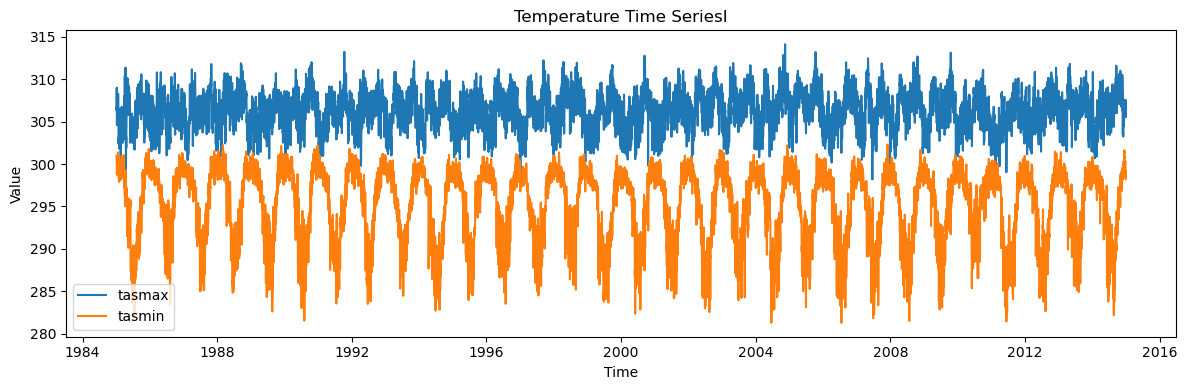

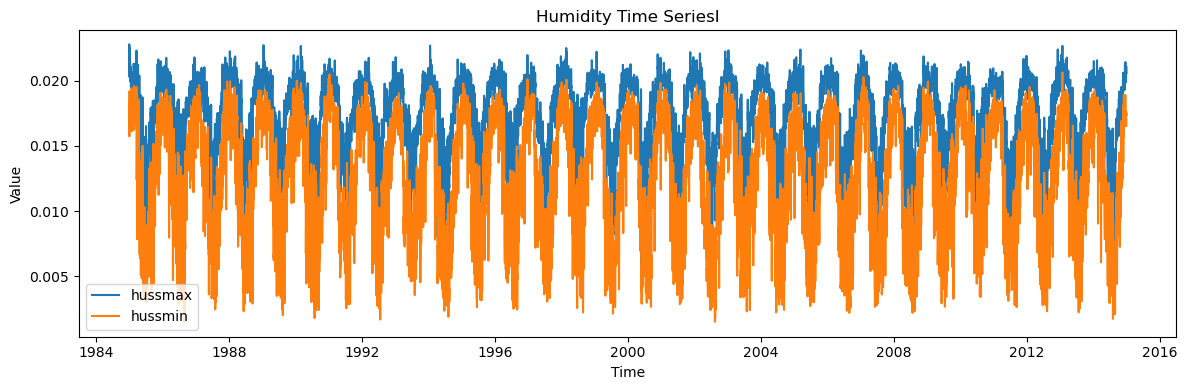

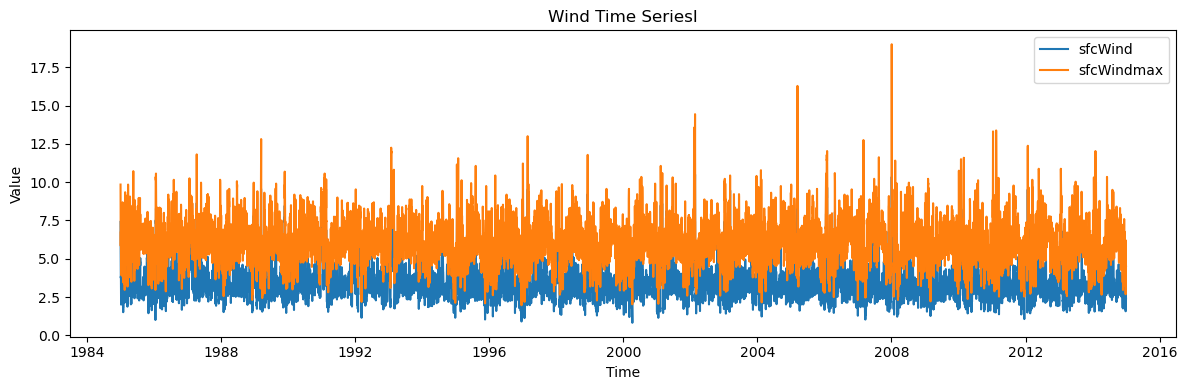

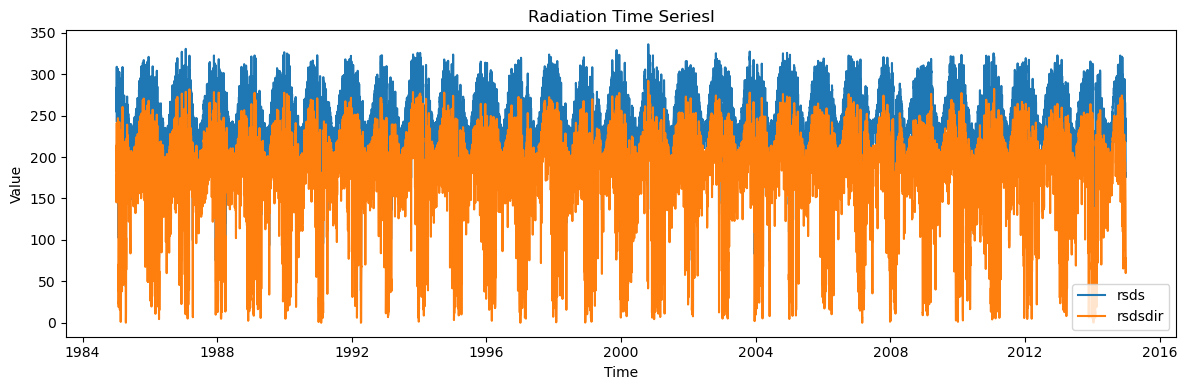

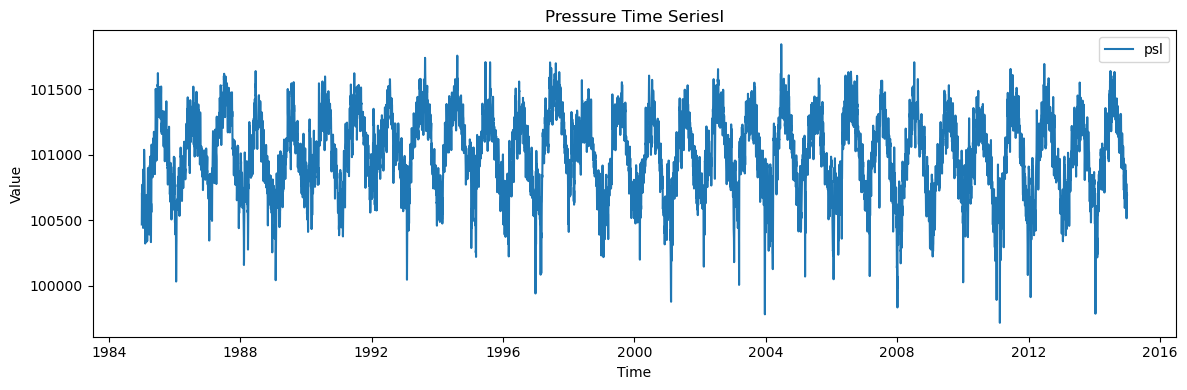

In [57]:
import matplotlib.pyplot as plt

# da_var = xr.open_dataset(f"{out_dir}Perth_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_1985-2014.nc")
da_var = xr.open_dataset(f"{out_dir}test_script2.nc")


plot_groups = {
    'Temperature': ['tasmax', 'tasmin'],
    'Humidity': ['hussmax', 'hussmin'],
    'Wind': ['sfcWind', 'sfcWindmax'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in da_var:
            da_var[var].plot(label=var)
    plt.title(f'{title} Time SeriesI')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


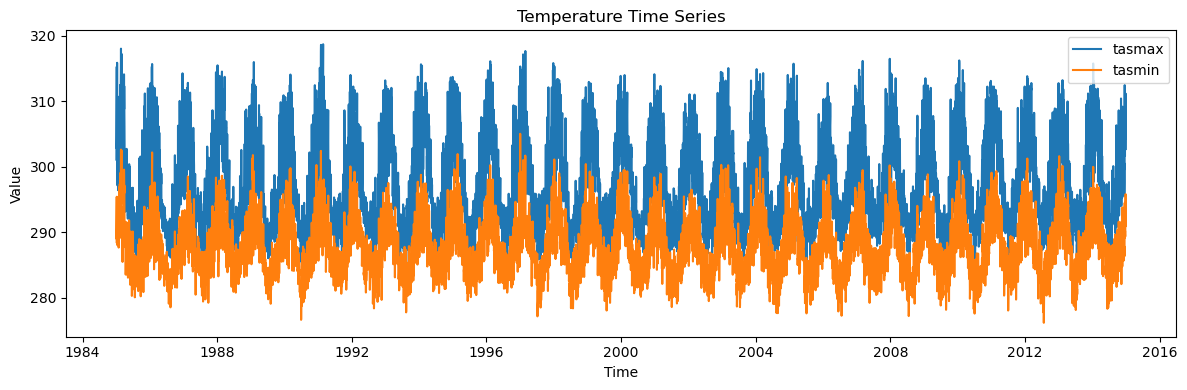

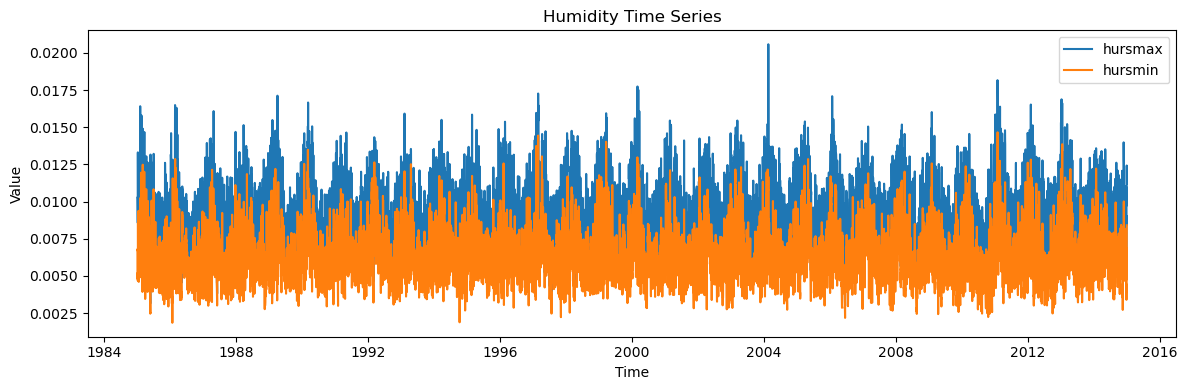

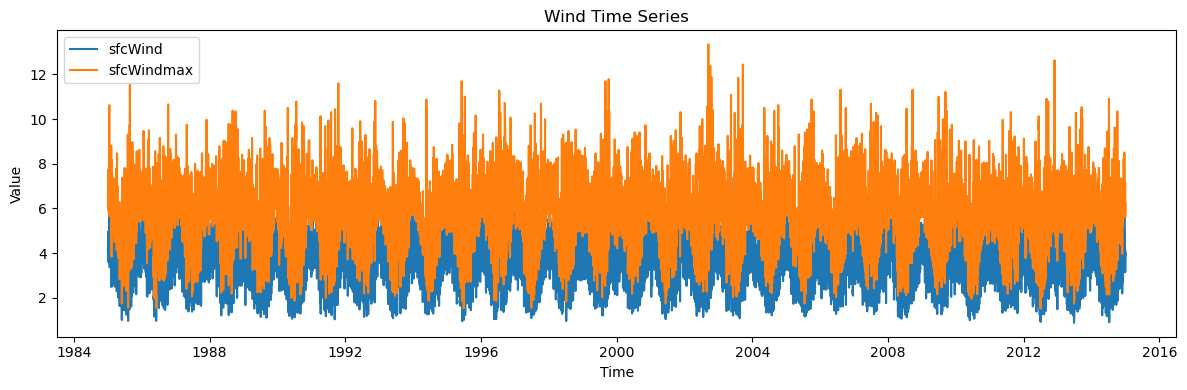

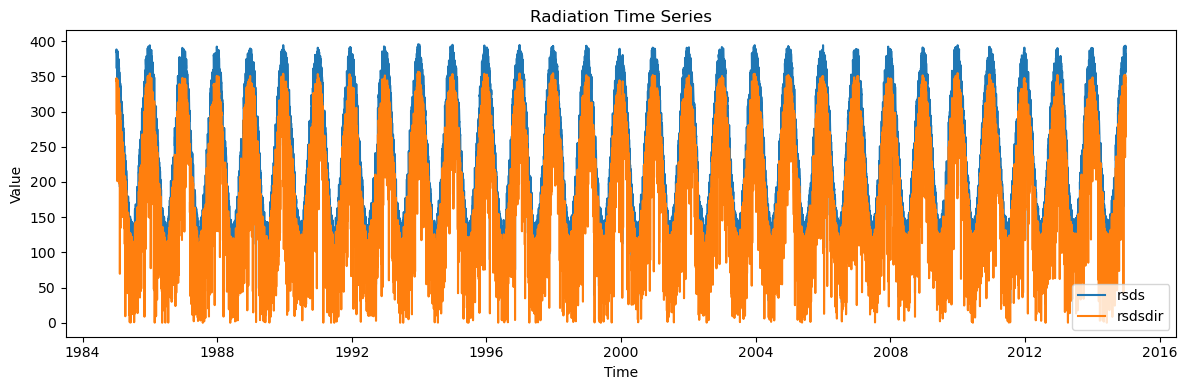

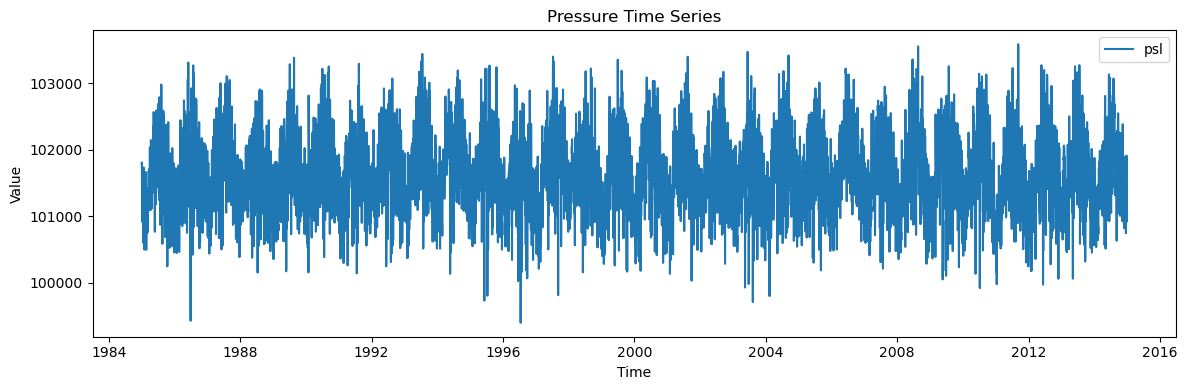

In [10]:
import matplotlib.pyplot as plt

da_var = xr.open_dataset(f"{out_dir}Perth_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_1985-2014.nc")

plot_groups = {
    'Temperature': ['tasmax', 'tasmin'],
    'Humidity': ['hursmax', 'hursmin'],
    'Wind': ['sfcWind', 'sfcWindmax'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in da_var:
            da_var[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


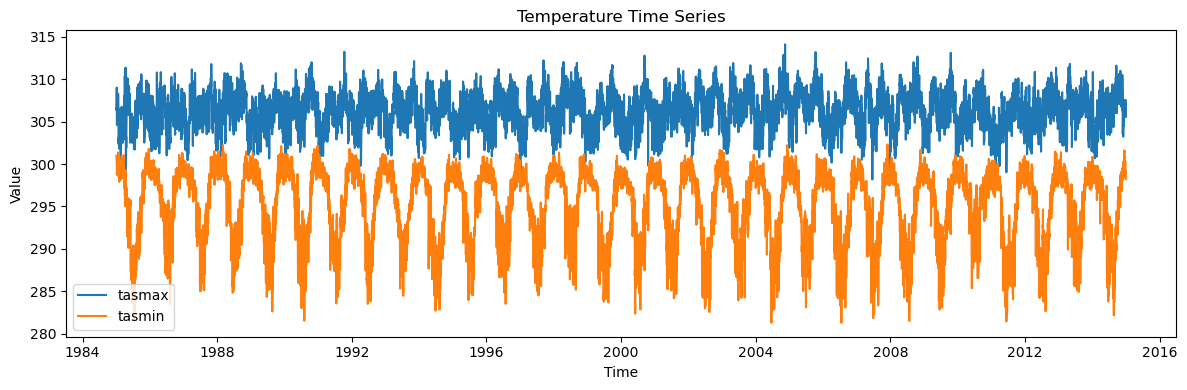

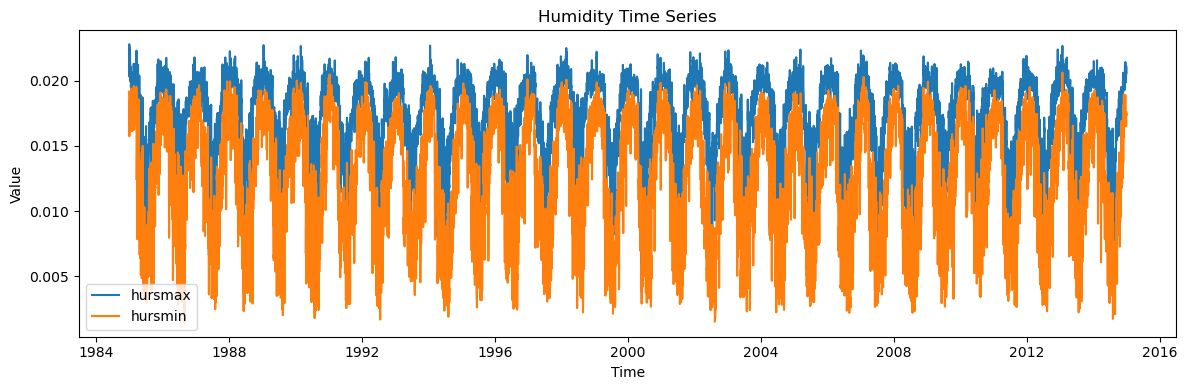

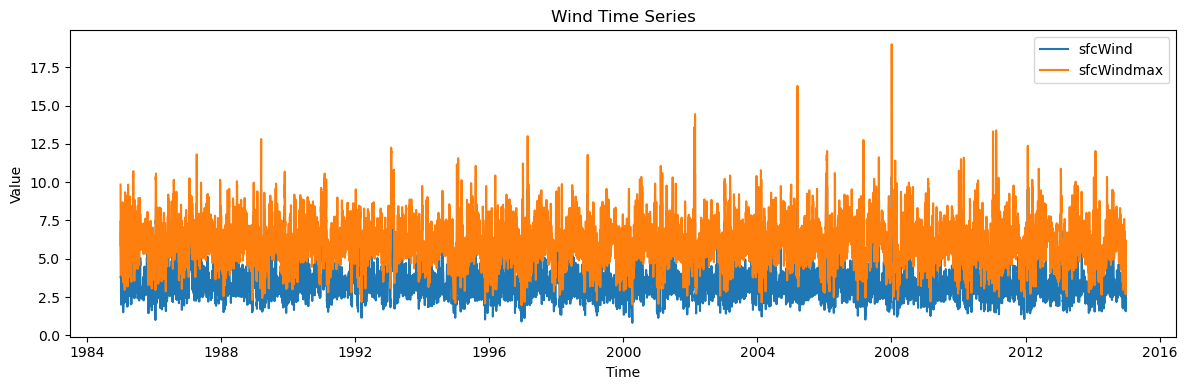

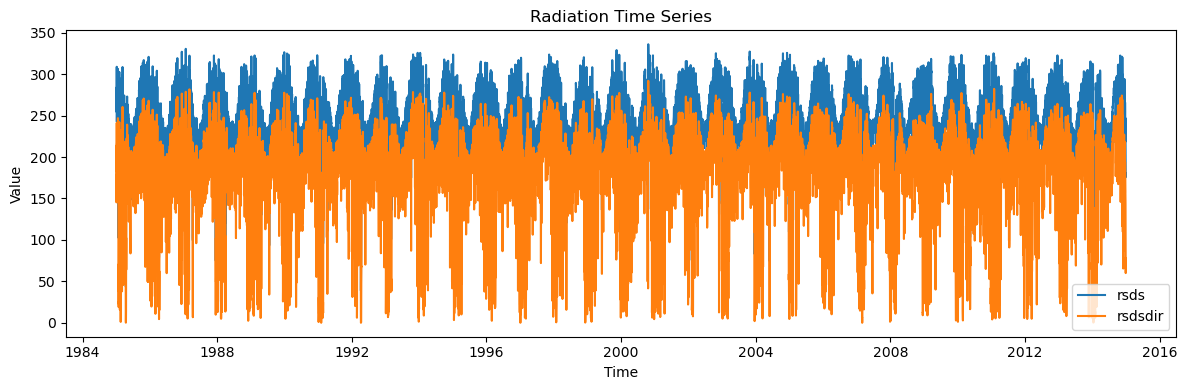

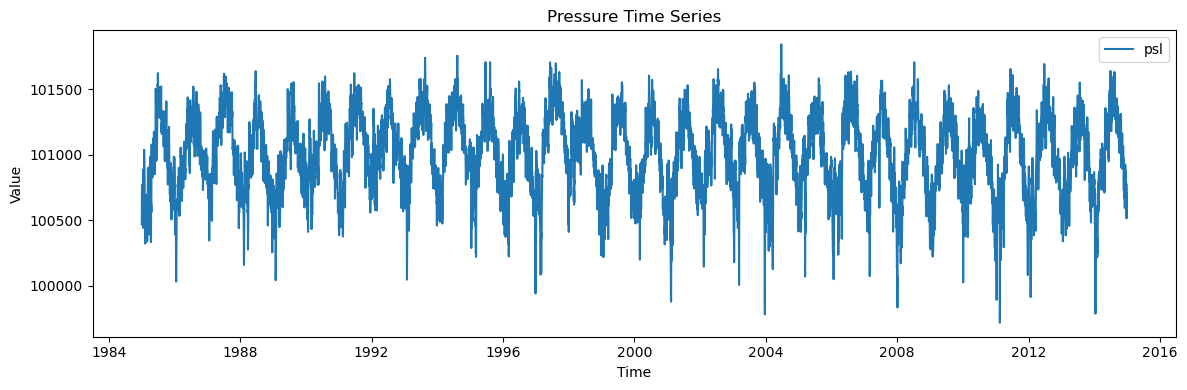

In [12]:
import matplotlib.pyplot as plt

da_var = xr.open_dataset(f"{out_dir}Darwin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_1985-2014.nc")

plot_groups = {
    'Temperature': ['tasmax', 'tasmin'],
    'Humidity': ['hursmax', 'hursmin'],
    'Wind': ['sfcWind', 'sfcWindmax'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in da_var:
            da_var[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


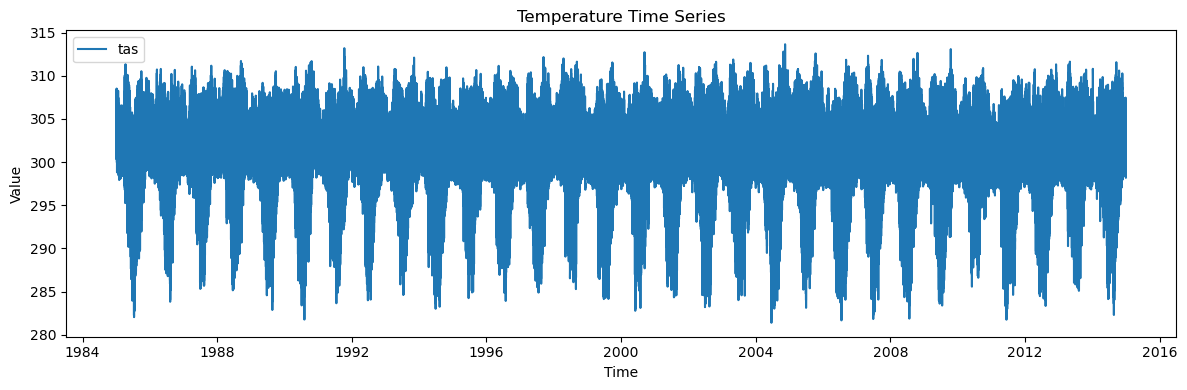

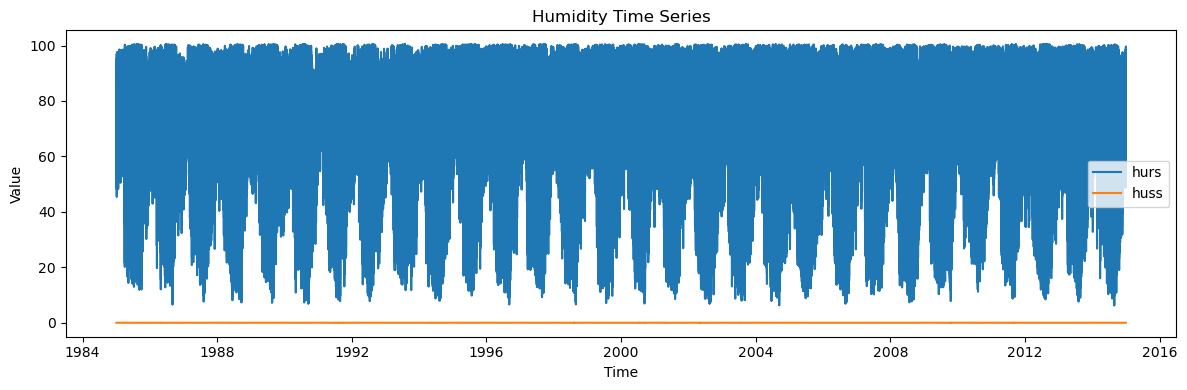

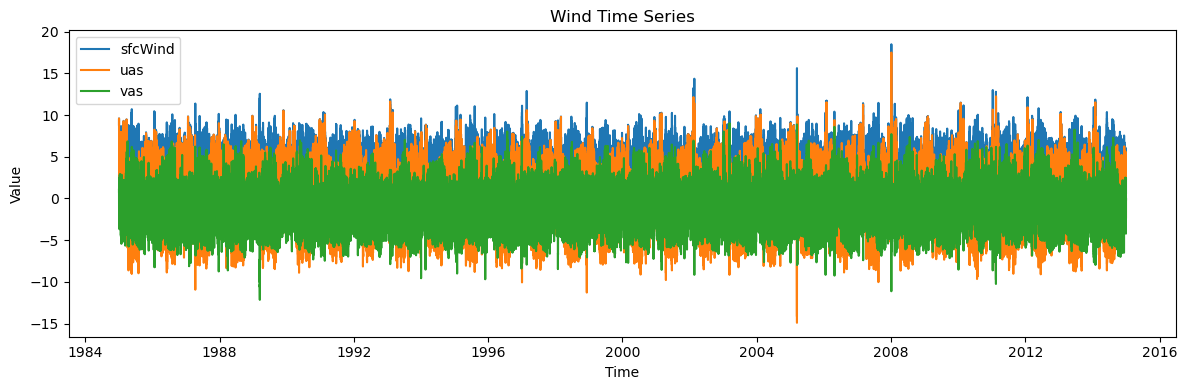

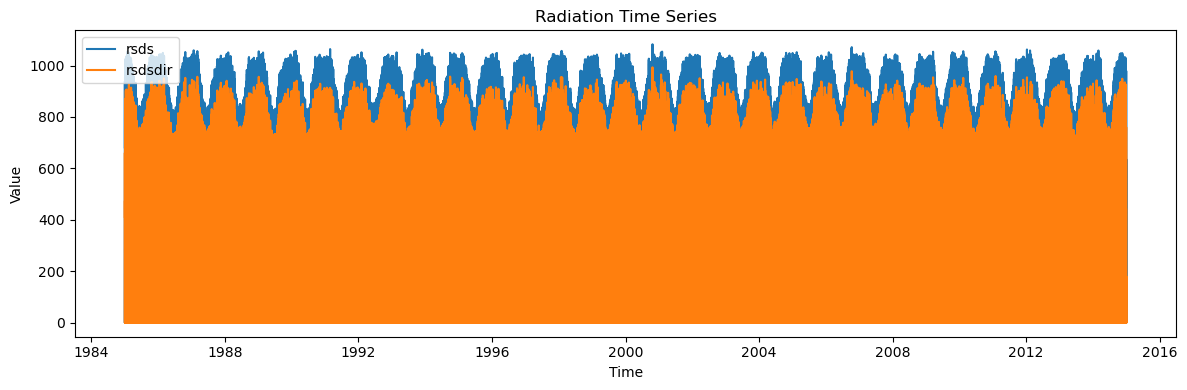

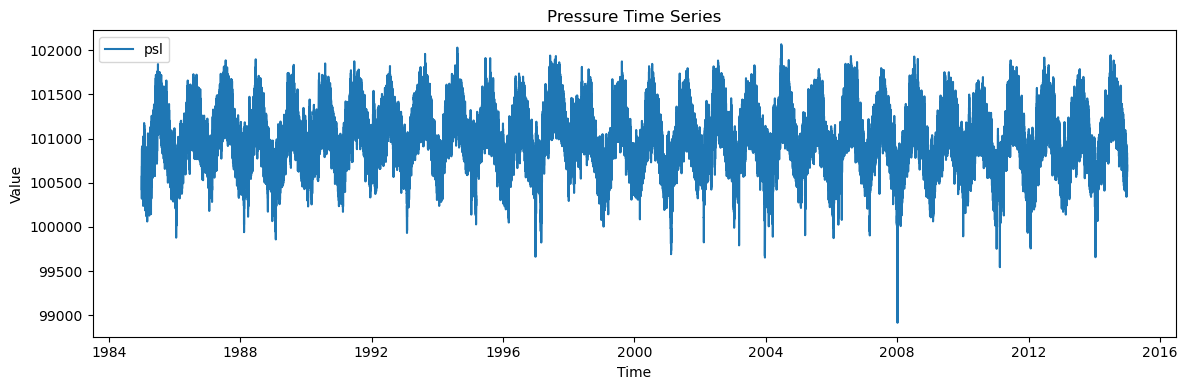

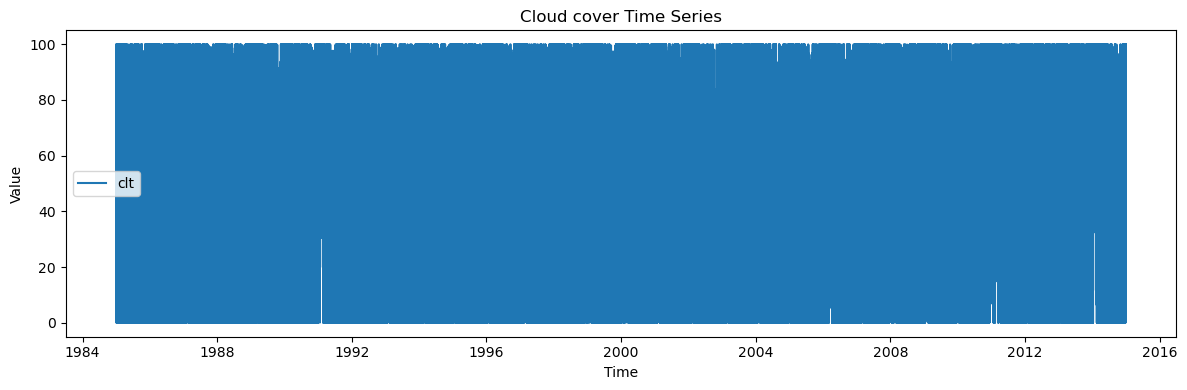

In [12]:
import matplotlib.pyplot as plt

# da_var = xr.open_dataset(f"{out_dir}Darwin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_1985-2014.nc").sel(time=slice('2010','2011'))
da_var = xr.open_dataset(f"{out_dir}test_script2hr.nc")
# da_var['tas'].plot()
plot_groups = {
    'Temperature': ['tas'],
    'Humidity': ['hurs', 'huss'],
    'Wind': ['sfcWind', 'uas','vas'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl'],
    'Cloud cover': ['clt']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in da_var:
            da_var[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
